# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore') # removing annoying Pandas warning

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_result(name):
    df = pandas.read_csv(io.BytesIO(zipfile.ZipFile(name).read('results.csv')))
    info = get_yaml(name, 'info.yaml')
    df['jobid'] = info['jobid']
    oarstat = get_yaml(name, 'oarstat.yaml')
    df['date'] = pandas.to_datetime(oarstat['startTime'], unit='s').date()
    return df

def read_sim_result(name):
    result = read_result(name)
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    installfile = info['installfile']
    result['model'] = installfile[8:10]  # filename of the form 'install_A1.yaml', so we get the 'A1'
    install_options = get_yaml(name, installfile)
    result['stochastic_cpu'] = install_options['stochastic_cpu']
    try:
        result['polynomial_dgemm'] = install_options['polynomial_dgemm']
    except KeyError:
        result['polynomial_dgemm'] = True
    result['stochastic_network'] = install_options['stochastic_network']
    repositories = info['git_repositories']
    repo = [r for r in repositories if r['path'] == 'hpl-2.2']
    assert len(repo) == 1
    hpl_hash = repo[0]['hash']
    if hpl_hash == '4ba643763846acfc5c74a3d3cfd3ac68b6f06704':
        print('bla')
        result['heterogeneous_dgemm'] = False
    else:
        try:
            result['heterogeneous_dgemm'] = install_options['heterogeneous_dgemm']
        except KeyError:
            result['heterogeneous_dgemm'] = True
    return result

reality_files_bad_cooling = [
    '../hpl/grenoble_2019-03-15_1855885.zip',
    '../hpl/grenoble_2019-03-18_1856059.zip',
    '../hpl/grenoble_2019-10-30_1891433.zip',
]
dfreal = pandas.concat([read_result(f) for f in reality_files_bad_cooling])
dfreal['cooling'] = 'bad'

reality_files = [
    '../hpl/grenoble_2018-10-10_1811810.zip',
    '../hpl/grenoble_2018-10-10_1811847.zip',
]
d = '../hpl/scaling/1'
reality_files += [os.path.join(d, f) for f in os.listdir(d)]
tmp = pandas.concat([read_result(f) for f in reality_files])
tmp['cooling'] = 'good'
dfreal = pandas.concat([dfreal, tmp])
dfreal['mode'] = 'Reality'

simulation_dir = 'scaling/1/'
simulation_files = [simulation_dir + f for f in os.listdir(simulation_dir)]
dfsim = pandas.concat([read_sim_result(f) for f in simulation_files])
dfsim['cooling'] = 'good'

simulation_dir = 'paper_sc19/performance/11/'
simulation_files_bad_cooling = [simulation_dir + f for f in os.listdir(simulation_dir)]
tmp = pandas.concat([read_sim_result(f) for f in simulation_files_bad_cooling])
tmp['cooling'] = 'bad'
dfsim = pandas.concat([dfsim, tmp])
dfsim['mode'] = 'Simulation'
dfsim = dfsim[~dfsim['stochastic_network'] & dfsim['stochastic_cpu'] & dfsim['heterogeneous_dgemm'] & dfsim['polynomial_dgemm']]

df = pandas.concat([dfsim, dfreal])
sizes = set(dfsim.matrix_size) & set(dfreal.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,heterogeneous_dgemm,cooling,dgemm_intercept,dtrsm_coefficient,dgemm_coefficient,dtrsm_intercept,mode,residual,start_timestamp,stop_timestamp
0,175000,128,32,32,1,2,2,1,0,8,...,True,good,NaN,NaN,NaN,NaN,Simulation,NaN,NaN,NaN
0,500000,128,32,32,1,2,2,1,0,8,...,True,good,NaN,NaN,NaN,NaN,Simulation,NaN,NaN,NaN
0,75000,128,32,32,1,2,2,1,0,8,...,True,good,NaN,NaN,NaN,NaN,Simulation,NaN,NaN,NaN
0,300000,128,32,32,1,2,2,1,0,8,...,True,good,NaN,NaN,NaN,NaN,Simulation,NaN,NaN,NaN
0,50000,128,32,32,1,2,2,1,0,8,...,True,good,NaN,NaN,NaN,NaN,Simulation,NaN,NaN,NaN


Dumping to a CSV file.

In [2]:
# Dumping to CSV
csv_columns = ['matrix_size', 'gflops', 'time', 'mode', 'cooling', 'date', 'jobid']
df[csv_columns].to_csv('/tmp/hpl_matrix_size.csv', index=False)

### Checking the parameters

In [3]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes', 'cooling', 'jobid', 'date',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,bcast,process_per_node,mem_align,proc_q,pfact,proc_p,rfact,block_size,swap,depth,thread_per_process
0,2,32,8,32,1,32,2,128,0,1,1


In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="1-32" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Comparing the real experiments

First, let's have a look at the different real experiments. Some of them were done a long time ago, some of them are very recent. Do we have similar performance?

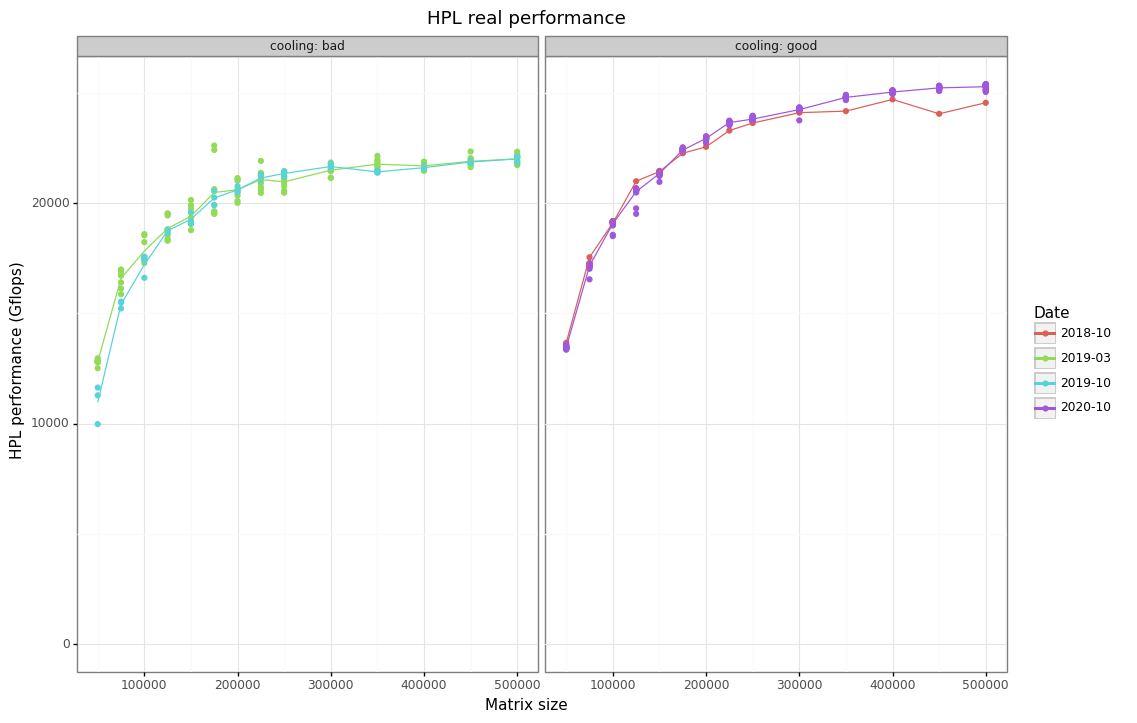

<ggplot: (-9223363242703322175)>

In [5]:
import numpy

dfreal['month'] = dfreal['date'].astype(str).str[:7]

(ggplot(dfreal)
    + aes(x='matrix_size', y='gflops', color='month')
    + theme_bw()
    + expand_limits(y=0)
    + geom_point()
    + stat_summary(fun_y = numpy.mean, geom='line')
    + xlab('Matrix size')
    + ylab('HPL performance (Gflops)')
    + labs(color='Date')
    + ggtitle('HPL real performance')
    + facet_wrap('cooling', labeller='label_both')
)

### Comparing the simulation with the real execution

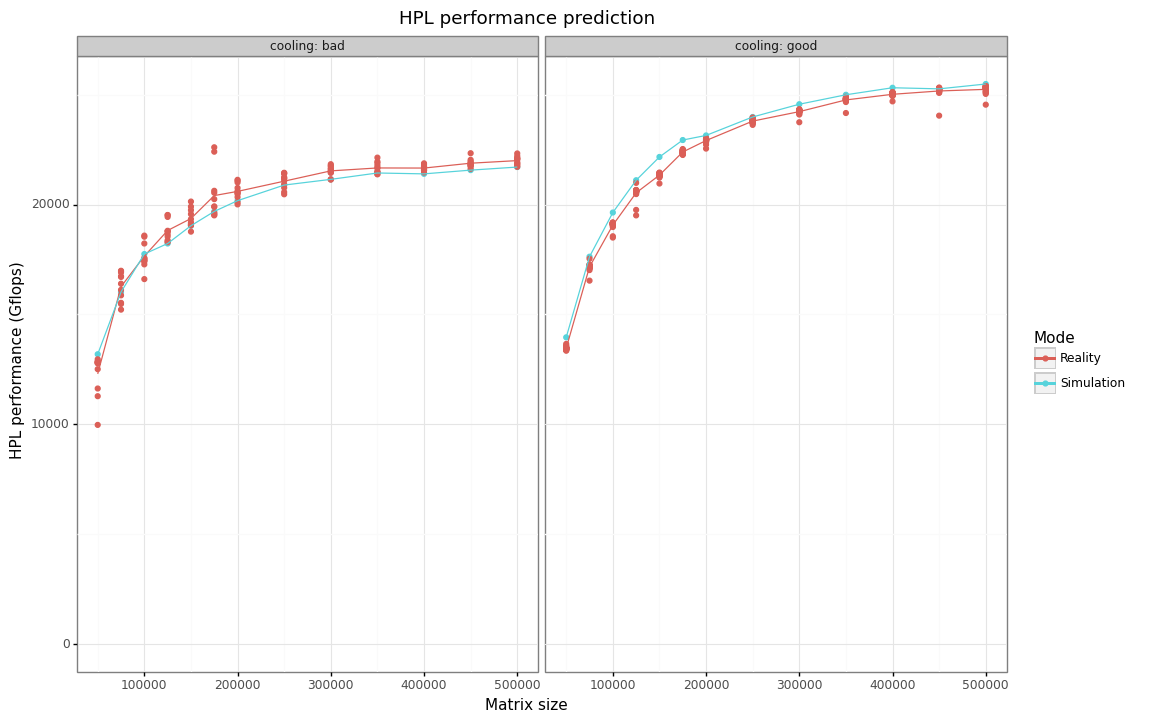

<ggplot: (8794049371894)>

In [6]:
import numpy

(ggplot(df)
    + aes(x='matrix_size', y='gflops', color='mode')
    + theme_bw()
    + expand_limits(y=0)
    + geom_point()
    + stat_summary(fun_y = numpy.mean, geom='line')
    + xlab('Matrix size')
    + ylab('HPL performance (Gflops)')
    + labs(color='Mode')
    + ggtitle('HPL performance prediction')
    + facet_wrap('cooling', labeller='label_both')
)